# PRICING ALGORITHM

Build a pricing strategy using the continuous set of prices p ∈ [0, 1] and Gaussian Processes.

## Gaussian Processes

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class RBFGaussianProcess:
    def __init__(self, scale=1, reg=1e-2):
        self.scale = scale
        self.reg = reg
        self.k_xx_inv = None

    def rbf_kernel_incr_inv(self, B, C, D):
        temp = np.linalg.inv(D - C @ self.k_xx_inv @ B)
        block1 = self.k_xx_inv + self.k_xx_inv @ B @ temp @ C @ self.k_xx_inv
        block2 = - self.k_xx_inv @ B @ temp
        block3 = - temp @ C @ self.k_xx_inv
        block4 = temp
        res1 = np.concatenate((block1, block2), axis=1)
        res2 = np.concatenate((block3, block4), axis=1)
        res = np.concatenate((res1, res2), axis=0)
        return res

    def rbf_kernel(self, a, b):
        a_ = a.reshape(-1, 1)
        b_ = b.reshape(-1, 1)
        output = -1 * np.ones((a_.shape[0], b_.shape[0]))
        for i in range(a_.shape[0]):
            output[i, :] = np.power(a_[i] - b_, 2).ravel()
        return np.exp(-self.scale * output)

    def fit(self, x=np.array([]), y=np.array([])):
        x,y = np.array(x),np.array(y)
        if self.k_xx_inv is None:
            self.y = y.reshape(-1,1)
            self.x = x.reshape(-1,1)
            k_xx = self.rbf_kernel(self.x, self.x) + self.reg * np.eye(self.x.shape[0])
            self.k_xx_inv = np.linalg.inv(k_xx)
        else:
            B = self.rbf_kernel(self.x, x)
            self.x = np.vstack((self.x, x))
            self.y = np.vstack((self.y, y))
            self.k_xx_inv = self.rbf_kernel_incr_inv(B, B.T, np.array([1 + self.reg]))

        return self

    def predict(self, x_predict):
        k = self.rbf_kernel(x_predict, self.x)

        mu_hat = k @ self.k_xx_inv @ self.y
        sigma_hat = 1 - np.diag(k @ self.k_xx_inv @ k.T)

        return mu_hat.ravel(), sigma_hat.ravel()

Here (in a stochastic setting) we have to choose a continuous set of prices p in [0,1]

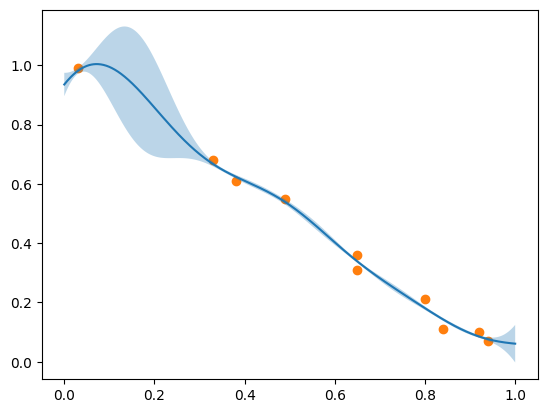

In [12]:
price_range = np.linspace(0,1,1000)
price_samples = np.random.sample(size=10).round(2) # randomly generating prices, sample gives a number btw 0 and 1

# how many customers do we have? it depends on the good we're selling
n_customers=100
conversion_probability = lambda p: 1-p # single probability to be specified depending again on the good (find reference)


# GP works well if the samples are in [0,1], thus we normalize them, i'm estimating here sales
normalized_sales_samples = np.random.binomial(n_customers, conversion_probability(price_samples))/n_customers

# Instantiate a Gaussian Process model, the scale is usually set of an order of magnitude below the order of magnitude of the range
# prices in the range (10,20) -> scale in the range (1,10)
gp = RBFGaussianProcess(scale=20)

gp.fit(price_samples, normalized_sales_samples)

mu, sigma = gp.predict(price_range) #i'm also getting the uncertainty

plt.figure()
plt.scatter(price_samples, normalized_sales_samples, color='C1')
plt.plot(price_range, mu)
plt.fill_between(price_range, mu-sigma, mu+sigma, alpha=0.3)
plt.show();
#blue is the interpolation

And now which algorithm should we use??


## The GP-UCB Algorithm

In [13]:
# From the agent's point of view, action set is [0,1]. If the actual actions are outside this
# set, we can always perform a rescaling outside the class.
class GPUCBAgent:
    def __init__(self, T, discretization=100):
        self.T = T
        self.arms = np.linspace(0, 1, discretization)
        self.gp = RBFGaussianProcess(scale=2).fit()
        self.a_t = None
        self.action_hist = np.array([])
        self.reward_hist = np.array([])
        self.mu_t = np.zeros(discretization)
        self.sigma_t = np.zeros(discretization)
        self.gamma = lambda t: np.log(t+1)**2 #un prodotto quindi 2 (n+1 prodotti)
        self.beta = lambda t: 1 + 0.5*np.sqrt(2 * (self.gamma(t) + 1 + np.log(T)))
        self.N_pulls = np.zeros(discretization)
        self.t = 0

    def pull_arm(self):
        self.mu_t, self.sigma_t = self.gp.predict(self.arms)
        ucbs = self.mu_t + self.beta(t) * self.sigma_t # mu+sigma is not enough anymore i need beta (exploration)
        self.a_t = np.argmax(ucbs)
        return self.arms[self.a_t]

    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.action_hist = np.append(self.action_hist, self.arms[self.a_t])
        self.reward_hist = np.append(self.reward_hist, r_t)
        self.gp = self.gp.fit(self.arms[self.a_t], r_t)
        self.t += 1

#### $UCB_t(a) = \mu_{t-1}(a) + \beta_t\sigma_{t-1}(a)$, for $ a\in [0,1]$ (continuous action set).

### $\beta_t$ is the parameter governing exploration. It accounts for two main factors: $\gamma_t$, which represents the maximum information that can be gained at round $t$, and a term in the order of $\mathcal{O}(\sqrt{\log(T)})$ that incentivizes exploration (in a similar way as UCB1).

USE GP-UCB LOOK AT THE PAPER HERE THERE ARE THE FORMULAS USED

In [14]:
class PricingEnvironment:
    def __init__(self, conversion_probability, cost):
        self.conversion_probability = conversion_probability
        self.cost = cost

    def round(self, p_t, n_t):  #provide my action,price and number of customers as well that can vary
        d_t = np.random.binomial(n_t, self.conversion_probability(p_t))
        r_t = (p_t - self.cost)*d_t # the reward is the profit
        return d_t, r_t

In [28]:

def rescale(x, min_x, max_x):
    return min_x + (max_x-min_x)*x


T = 500
min_price, max_price = 0, 1
conversion_probability = lambda p: 1-p
prices = np.linspace(min_price, max_price, 1000)
cost = 0.1
reward_function = lambda price, n_sales: (price-cost)*n_sales
maximum_profit = reward_function(max(prices), n_customers) # the maximum possible reward is selling at the maximum price to every possible customer

n_customers = 100
agent = GPUCBAgent(T)
np.random.seed(2)
env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)

# let's compute the clairvoyant

profit_curve = reward_function(prices, n_customers*conversion_probability(prices))
best_price_index = np.argmax(profit_curve)
best_price = prices[best_price_index]
expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], T)

agent_rewards = np.array([])
for t in range(T):
    p_t = agent.pull_arm()
    p_t = rescale(p_t, min_price, max_price)
    d_t, r_t = env.round(p_t, n_t=n_customers)
    agent.update(r_t/n_customers)
    agent_rewards = np.append(agent_rewards, r_t)

cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)

In [29]:
profits = agent.reward_hist
prices = rescale(agent.action_hist, min_price, max_price)

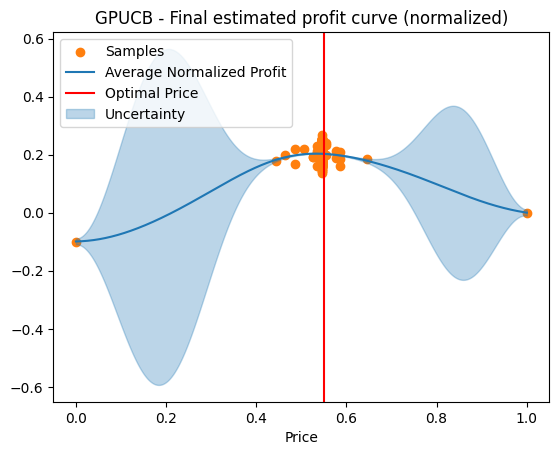

In [30]:
gp = RBFGaussianProcess(scale=20)
gp.fit(prices, profits)
mu, sigma = gp.predict(np.linspace(0,1,1000))
plt.scatter(prices, profits, label='Samples', color='C1')
plt.plot(np.linspace(0,1,1000), mu, label='Average Normalized Profit')
plt.axvline(best_price, color='red',label='Optimal Price')
plt.fill_between(np.linspace(0,1,1000), mu-sigma, mu+sigma, alpha=0.3, label='Uncertainty', color='C0')
plt.title('GPUCB - Final estimated profit curve (normalized)')
plt.xlabel('Price')
plt.legend()
plt.show();

### How's the cumulative regret?

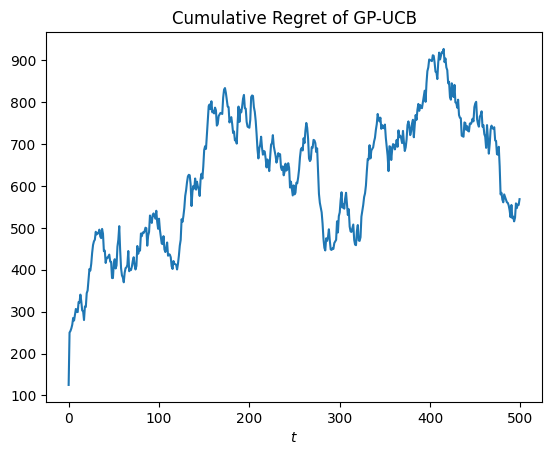

In [ ]:
plt.figure()
plt.plot(cumulative_regret)
plt.title('Cumulative Regret of GP-UCB')
plt.xlabel('$t$')
plt.show();

### Another drawback: instability! Mainly due to Gaussian Processes tendency to overfit.

### The algorithm seems to perform better than a UCB1 strategy with price discretization, but we need a more reliable estimation

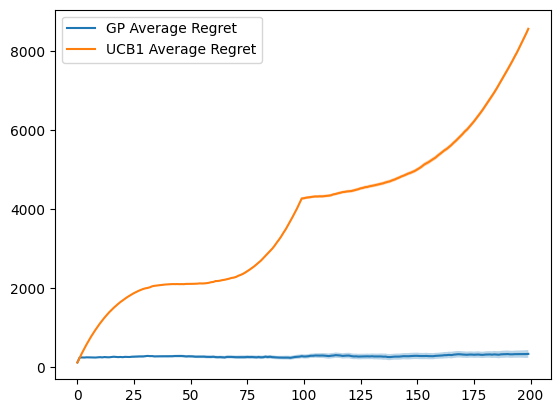

In [ ]:
def rescale(x, min_x, max_x):
    return min_x + (max_x-min_x)*x

conversion_probability = lambda p: 1-p/20
reward_function = lambda price, n_sales: (price-cost)*n_sales
maximum_profit = reward_function(max(prices), n_customers) # the maximum possible reward is selling at the maximum price to every possible customer

T = 200
K = 100 # arbitrary discretization

min_price, max_price = 10, 20
n_customers = 100
cost = 10

# let's compute the clairvoyant
prices = np.linspace(min_price, max_price, K)
profit_curve = reward_function(prices, n_customers*conversion_probability(prices))
best_price_index = np.argmax(profit_curve)
best_price = prices[best_price_index]
expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], T)

n_epochs = 20

gp_all_cumulative_regrets = []
ucb_all_cumulative_regrets = []
for i in range(n_epochs):
    gp_agent = GPUCBAgent(T)
    ucb1_agent = UCB1Agent(K, T, range=maximum_profit)

    np.random.seed(10*i)
    env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)

    gp_agent_rewards = np.array([])
    ucb_agent_rewards = np.array([])
    for t in range(T):
        p_t = gp_agent.pull_arm()
        p_t = rescale(p_t, min_price, max_price)
        d_t, r_t = env.round(p_t, n_t=n_customers)
        gp_agent.update(r_t/n_customers)
        gp_agent_rewards = np.append(gp_agent_rewards, r_t)

        p_t = ucb1_agent.pull_arm()
        p_t = prices[p_t]
        d_t, r_t = env.round(p_t, n_t=n_customers)
        ucb1_agent.update(r_t)
        ucb_agent_rewards = np.append(ucb_agent_rewards, r_t)

    gp_all_cumulative_regrets.append(np.cumsum(expected_clairvoyant_rewards-gp_agent_rewards))

    ucb_all_cumulative_regrets.append(np.cumsum(expected_clairvoyant_rewards-ucb_agent_rewards))

gp_all_cumulative_regrets = np.array(gp_all_cumulative_regrets)
ucb_all_cumulative_regrets = np.array(ucb_all_cumulative_regrets)

gp_average_cumulative_regret = gp_all_cumulative_regrets.mean(axis=0)
gp_cumulative_regret_std = gp_all_cumulative_regrets.std(axis=0)

ucb_average_cumulative_regret = ucb_all_cumulative_regrets.mean(axis=0)
ucb_cumulative_regret_std = ucb_all_cumulative_regrets.std(axis=0)

plt.plot(np.arange(T), gp_average_cumulative_regret, label='GP Average Regret')
plt.fill_between(np.arange(T),
                gp_average_cumulative_regret-gp_cumulative_regret_std/np.sqrt(n_epochs),
                gp_average_cumulative_regret+gp_cumulative_regret_std/np.sqrt(n_epochs),
                alpha=0.3)
plt.plot(np.arange(T), ucb_average_cumulative_regret, label='UCB1 Average Regret')
plt.fill_between(np.arange(T),
                ucb_average_cumulative_regret-ucb_cumulative_regret_std/np.sqrt(n_epochs),
                ucb_average_cumulative_regret+ucb_cumulative_regret_std/np.sqrt(n_epochs),
                alpha=0.3)
plt.legend()
plt.show();

### The performance gap is clear. Why the weird behavior of UCB1's average cumulative regret?

### Note: with $T=200$, UCB1 has to spend half of its time just to try all arms once!

### What would be the discretization prescribed by theory?

In [ ]:
epsilon = T**(-0.33)
K = int(1/epsilon)
K

5

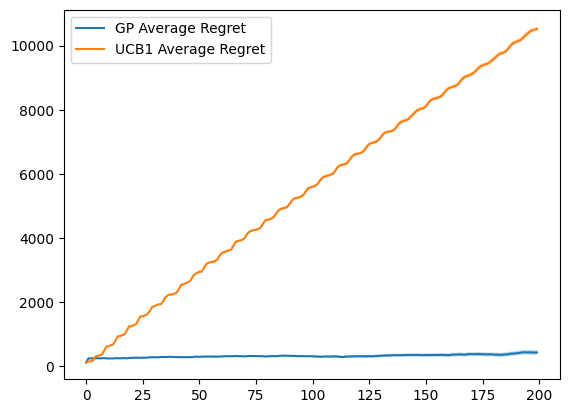

In [ ]:
def rescale(x, min_x, max_x):
    return min_x + (max_x-min_x)*x

conversion_probability = lambda p: 1-p/20
reward_function = lambda price, n_sales: (price-cost)*n_sales
maximum_profit = reward_function(max(prices), n_customers) # the maximum possible reward is selling at the maximum price to every possible customer

T = 200

min_price, max_price = 10, 20
n_customers = 100
cost = 10

# let's compute the clairvoyant
prices = np.linspace(min_price, max_price, K)
profit_curve = reward_function(prices, n_customers*conversion_probability(prices))
best_price_index = np.argmax(profit_curve)
best_price = prices[best_price_index]
expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], T)

n_epochs = 20

gp_all_cumulative_regrets = []
ucb_all_cumulative_regrets = []
for i in range(n_epochs):
    gp_agent = GPUCBAgent(T)
    ucb1_agent = UCB1Agent(K, T, range=maximum_profit)

    np.random.seed(10*i)
    env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)

    gp_agent_rewards = np.array([])
    ucb_agent_rewards = np.array([])
    for t in range(T):
        p_t = gp_agent.pull_arm()
        p_t = rescale(p_t, min_price, max_price)
        d_t, r_t = env.round(p_t, n_t=n_customers)
        gp_agent.update(r_t/n_customers)
        gp_agent_rewards = np.append(gp_agent_rewards, r_t)

        p_t = ucb1_agent.pull_arm()
        p_t = prices[p_t]
        d_t, r_t = env.round(p_t, n_t=n_customers)
        ucb1_agent.update(r_t)
        ucb_agent_rewards = np.append(ucb_agent_rewards, r_t)

    gp_all_cumulative_regrets.append(np.cumsum(expected_clairvoyant_rewards-gp_agent_rewards))

    ucb_all_cumulative_regrets.append(np.cumsum(expected_clairvoyant_rewards-ucb_agent_rewards))

gp_all_cumulative_regrets = np.array(gp_all_cumulative_regrets)
ucb_all_cumulative_regrets = np.array(ucb_all_cumulative_regrets)

gp_average_cumulative_regret = gp_all_cumulative_regrets.mean(axis=0)
gp_cumulative_regret_std = gp_all_cumulative_regrets.std(axis=0)

ucb_average_cumulative_regret = ucb_all_cumulative_regrets.mean(axis=0)
ucb_cumulative_regret_std = ucb_all_cumulative_regrets.std(axis=0)

plt.plot(np.arange(T), gp_average_cumulative_regret, label='GP Average Regret')
plt.fill_between(np.arange(T),
                gp_average_cumulative_regret-gp_cumulative_regret_std/np.sqrt(n_epochs),
                gp_average_cumulative_regret+gp_cumulative_regret_std/np.sqrt(n_epochs),
                alpha=0.3)
plt.plot(np.arange(T), ucb_average_cumulative_regret, label='UCB1 Average Regret')
plt.fill_between(np.arange(T),
                ucb_average_cumulative_regret-ucb_cumulative_regret_std/np.sqrt(n_epochs),
                ucb_average_cumulative_regret+ucb_cumulative_regret_std/np.sqrt(n_epochs),
                alpha=0.3)
plt.legend()
plt.show();

### Comparable performances, but this time the regret seems to have at least a sub-linear behavior ($\mathcal{O}(T^\frac{2}{3}\log(T))$).

### Regret of GP-UCB:
### $$ R_T = \mathcal{O}(\sqrt{T}\gamma_T) =  \mathcal{O}(\sqrt{T}\log(T)^{d+1})$$
### where $d$ is the dimension of the action space, in our case $d=1$. Note that the total information gain term scales exponentially with the dimension of the action space -> curse of dimensionality!

### Multi-dimensional action spaces ($d>1$) are very important in dynamic pricing, since they model the scenario in which a seller is offering multiple product, with possibly correlated demands. GP-UCB can be extended to the multi-dimensional scenario, see the reference above.

In [ ]:
#??


# BIDDING ALGORITHM


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#!pip install scipy
from scipy import stats
from scipy import optimize

A company runs a marketing campaign for some months. The company faces a sequence of auctions. -> advertisers's perspective.

## Learning in Repeated Advertising Auctions

### Important Quantities
Given and ad $a$ and a slot $s$, each time $t$ a user arrives:
- $\lambda_s$: probability that the slot $s$ is observed by the user.
- $q_a$: ad's *click-through-rate*, i.e., probability that the ad is clicked by user
- $v_a$: ad's profit per click (e.g., expected profit from sale) - how much i will likely gain, our main interest

### Assumptions of this model:

- All the quantities are **fixed** and don't vary with time.
- Ad's CTR $q_a$ and profit-per-click $v_a$ don't depend on the slot. (multiple slot action common assumption)
- Prominence $\lambda_s$ pdoesn't depend on ad.

In [ ]:
class Auction:
    def __init__(self, *args, **kwargs):
        pass

    def get_winners(self, bids):
        pass

    def get_payments_per_click(self, winners, values, bids):
        pass

        #we have to return to the environment the winners and the payment

    def round(self, bids):
        winners, values = self.get_winners(bids) # allocation mechanism!
        payments_per_click = self.get_payments_per_click(winners, values, bids)
        return winners, payments_per_click


As specified we're in the setting of second price auction -  truthful actions

# Truthful Auctions


In [ ]:
class SecondPriceAuction(Auction):
    def __init__(self, ctrs):
        self.ctrs = ctrs
        self.n_adv = len(self.ctrs)

    def get_winners(self, bids):
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values) #ranks the advertisers
        winner = adv_ranking[-1] #gets the winner
        return winner, adv_values

    def get_payments_per_click(self, winners, values, bids):
        adv_ranking = np.argsort(values)
        second = adv_ranking[-2] #the second winner
        payment = values[second]/self.ctrs[winners] #normalized by the click to rate of the winner
        return payment.round(2)

## Advertiser's Perspective: learning in repeated second price auctions

 Advertisers have a budget that they can't ecced at all costs

#### We will assume, from now on, that all CTRs are equal to 1, so we don't have to multiply for the click to rate -> are we going to follow this ideal assumption? look at some papers or leave it like that

#### What is the best **and feasible** sequence of bids I can do? How much cumulative utility does a clairvoyant gain?

what is less straight forwards is the clairvoyant, which has also to satisfy my budget. we can't just discretize the bids and find the largest utility because i'm not taking into account the budget. also there is the presence of competitors bids for example we can assume bidders to be adversarial or stochastic or deterministic -> 3 different situations: we're in a stochastic setting (is this the meaning of stochastic environment?)

#### I know, for each round, what will be the highest bid. Now I have to solve an optimization problem and find out how to allocate my bids optimally.

this is trivial: preserve its budget for when all the others have depleted and then 0 because when there's a tie i win the auction, i just have to decide if i want to bid so they bid 1 even though then since it is second price i want to win the ones with the smaller second bids-> that's why i'm reasoning like this


In [ ]:
### As a re-usable function:
def get_clairvoyant_truthful(B, my_valuation, m_t, n_users):
    ## I compute my sequence of utilities at every round
    utility = (my_valuation-m_t)*(my_valuation>=m_t) #like in the slides
    ## Now I have to find the sequence of m_t summing up to budget B and having the maximum sum of utility
    ## In second price auctions, I can find the sequence **greedily**:
    sorted_round_utility = np.flip(np.argsort(utility)) # sorted rounds, from most profitable to less profitable
    clairvoyant_utilities = np.zeros(n_users)
    clairvoyant_bids= np.zeros(n_users)
    clairvoyant_payments = np.zeros(n_users)
    c = 0 #to keep track of my expenses
    i = 0
    while c <= B-1 and i < n_users:
        clairvoyant_bids[sorted_round_utility[i]] = 1
        clairvoyant_utilities[sorted_round_utility[i]] = utility[sorted_round_utility[i]]
        clairvoyant_payments[sorted_round_utility[i]] = m_t[sorted_round_utility[i]]
        c += m_t[sorted_round_utility[i]]
        i+=1
    return clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments

In [ ]:
### Stochastic Bidders: my competitors sample their bids from
### probability distributions

n_advertisers = 3
n_users = 1000
B = 50

# simple scenario: competitors sample bids from a uniform
other_bids = np.random.uniform(0, 10*B/n_users, size = (n_advertisers, n_users))

# I assume that competitors may have a larger budget than mine (10*B), but they may
# not deplete it.

In [ ]:
m_t = other_bids.max(axis=0) ### maximum bid at every round, NOT IN EXPECTATION
m_t[:10]

array([0.19831998, 0.35141997, 0.4514485 , 0.42252995, 0.47984272,
       0.45040339, 0.40148324, 0.33236423, 0.49853575, 0.49838762])

uniform distributions have a beta distributeded maximum.

#### I can, again, use the greedy strategy for find the clairvoyant's bids and utilities

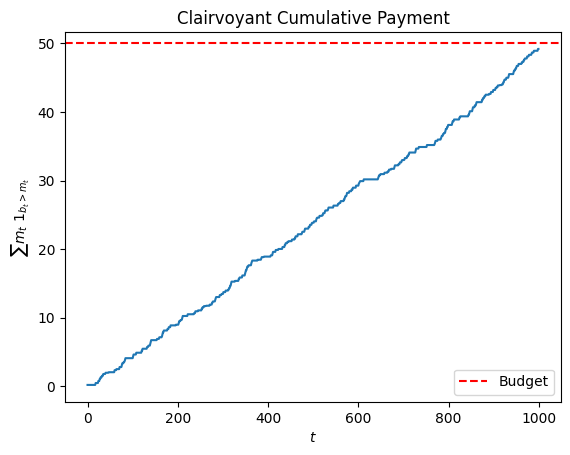

In [ ]:
B = 50
my_valuation = 0.8

clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = get_clairvoyant_truthful(B, my_valuation, m_t, n_users)

plt.title('Clairvoyant Cumulative Payment')
plt.plot(np.cumsum(clairvoyant_payments))
plt.axhline(B, color='red', linestyle='--', label='Budget')
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$\sum m_t~ 1_{b_t > m_t}$')
plt.show();

It's allocating its a budget in a uniform way, stochastic bidders will behave the same so i find the optimal one and play it at each round.

#### What agent can I design without knowing all the information a priori?

### Budget Pacing

In [ ]:
class MultiplicativePacingAgent:
    def __init__(self, valuation, budget, T, eta):
        self.valuation = valuation
        self.budget = budget
        self.eta = eta
        self.T = T
        self.rho = self.budget/self.T
        self.lmbd = 1
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.valuation/(self.lmbd+1)

    def update(self, f_t, c_t):
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t),
                            a_min=0, a_max=1/self.rho)
        self.budget -= c_t

In [ ]:
# advertisers' fixed parameters
## we assume that our agent has the FIRST index, e.g. our q_a*v_a = 0.56
n_advertisers = 4 # four advertisers, including myself
ctrs = np.ones(n_advertisers)
my_valuation = 0.8
B = 150

# environmental settings
n_users = 1000

# competitors
other_bids = np.random.uniform(0, 1, size = (n_advertisers-1, n_users))
#could bid 1000 and wi all of them, it is not impossible
#this is a hard setting
m_t = other_bids.max(axis=0)
## I'm considering competitors stronger than me, since they are free to exceed my budget

clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = get_clairvoyant_truthful(B, my_valuation, m_t, n_users)

In [ ]:
#pacing strategy
#here see the theory
eta = 1/np.sqrt(n_users) # from theory
agent = MultiplicativePacingAgent(valuation=my_valuation,
                                  budget=B,
                                  T=n_users,
                                  eta=eta)

auction = SecondPriceAuction(ctrs)

utilities = np.array([])
my_bids = np.array([])
my_payments = np.array([])
total_wins = 0

np.random.seed(18)
for u in range(n_users):
    # interaction
    my_bid = agent.bid()
    bids = np.append(my_bid, other_bids[:, u].ravel())
    winners, payments_per_click = auction.round(bids=bids)
    my_win = int(winners==0)
    f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
    agent.update(f_t, c_t)
    # logging
    utilities = np.append(utilities, f_t)
    my_bids = np.append(my_bids, my_bid)
    my_payments = np.append(my_payments, c_t)
    total_wins+=my_win
print(f'Total # of Wins: {total_wins}')

Total # of Wins: 259


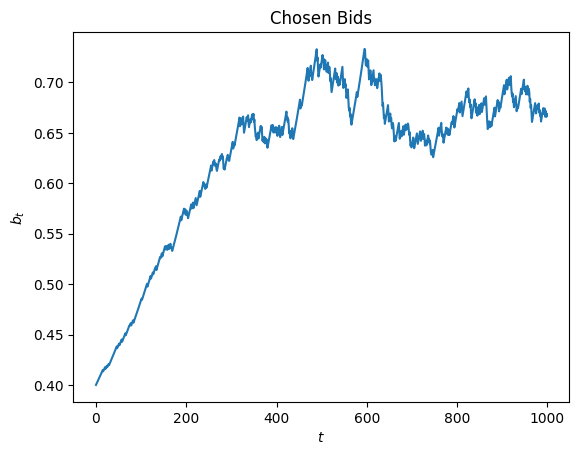

In [ ]:
plt.plot(my_bids)
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids')
plt.show()

at some point i stabilize around a value which means that there is an optimal strategy that i'm trying to learn.

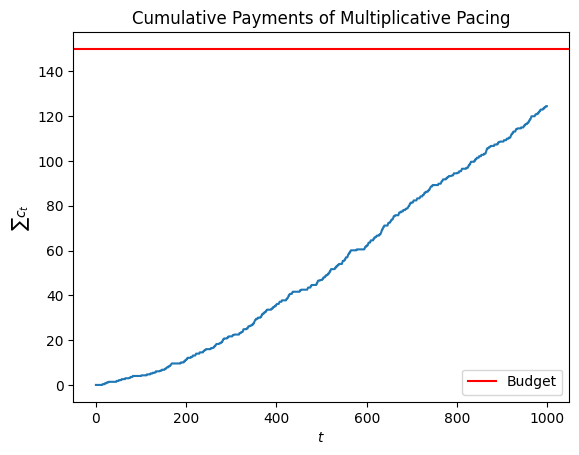

In [ ]:
cumulative_payments = np.cumsum(my_payments)
plt.plot(cumulative_payments)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

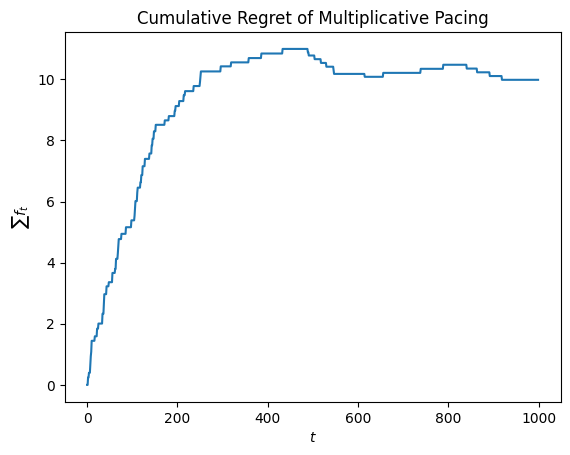

In [ ]:
cumulative_regret = np.cumsum(clairvoyant_utilities-utilities)
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum f_t$')
plt.title('Cumulative Regret of Multiplicative Pacing')
plt.show()

to estimare pseudo regret: do multiple curve and then average (this is how you have to do) show the uncertainty also after multiple epochs (like in the bandit setting) see that